<center> <h1> Enhanced Index Tracking with Distributionally Robust Optimization <h1/> <center/>

## Imports

In [1]:
import sys
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mosek.fusion import *
from tqdm import tqdm
import time
import scipy.stats as sps

In [2]:
from EITP.Models.Model1 import IndexTracker as firstModel;
from EITP.Models.Model1DRO import IndexTracker as firstModelDRO;
from EITP.Models.EWCVaR import IndexTracker as EWCVaR;
from EITP.Backtesting.VisualComparison import Visualizer;
from EITP.Backtesting.QuantitativeComparison import PerformanceMetrics;

## Choose Data Set

In [3]:
# Choose from 
# 1. DD
# 2. DU
# 3. UD
# 4. UU

whichData = "UU";

## Model Controller

In [4]:
# Enhanced returns
alphaAnnualy = 0.0510;
alphaWeekly = (1 + alphaAnnualy)**(1/52) - 1;

# Generic controls
shortingCapacity = 0.00;
selectBeta = [0.95];
selectGamma = [0];

# DRO controls
selectedEpsilon = 10**(-0.8);
lowerEps = 10**(-16);
upperEps = 10**(-0.5);
epsCollection = np.linspace(lowerEps, upperEps, 100);
selectedEpsilonIndex = np.argmin([(i - selectedEpsilon)**(2) for i in epsCollection]);

## Plot Settings

In [5]:
OoS_ylimits = [80,155];

## Load Training and Test Data

In [6]:
inSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/IS-GMS-{}.csv".format(whichData), header=None);
outSample = pd.read_csv("./Data/Data from Guastaroba (2020)/CSV/OoS-GMS-{}.csv".format(whichData), header=None);

# Out-of-sample data is in levels
IndexOoS = outSample.pct_change();
IndexOoS = IndexOoS.values[:,0]
IndexOoS = IndexOoS[1:];
AssetsOoS = outSample.pct_change();
AssetsOoS = AssetsOoS.values[:,1:]
AssetsOoS = AssetsOoS[1:];

# In-sample data is in returns
IndexIS = inSample.iloc[:,0].values
AssetsIS = inSample.iloc[:,1:].values

## Parameter Estimation

In [ ]:
# Train Base Model
M1 = firstModel(returnsAssets=AssetsIS, returnsIndex=IndexIS, betas=[0.95], gammas=[0.0], shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
M1.solve();

# Train Base Model with DRO
M1DRO = firstModelDRO(returnsAssets=AssetsIS, returnsIndex=IndexIS, betas=[0.95], gammas=[0.0], shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
M1DRO.solve(epsCollection=[selectedEpsilon]);

# Train EWCVaR
EWCVaR1 = EWCVaR(returnsAssets=AssetsIS, returnsIndex=IndexIS, shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
EWCVaR1.solve([0.05, 0.25, 0.50]);

<center> <h1>Testing of Package 'EITP'<h1/> <center/>

# Visual Comparison

### 1) Base Model

Start by instantiating the model.

In [ ]:
# Show in-sample performance visually
assetsM1_IS, indexM1_IS, enhancedIndexM1_IS, portfolioM1_IS = M1.IS(saveFile="Base_IS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True);

# Show out-of-sample performance visually
assetsM1_OoS, indexM1_OoS, enhancedIndexM1_OoS, portfolioM1_OoS = M1.OoS(AssetsOoS, IndexOoS, saveFile="Base_OoS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True, ylim=OoS_ylimits);

### 2) Base Model with DRO

In [ ]:
# Show in-sample performance visually
assetsM1DRO_IS, indexM1DRO_IS, enhancedIndexM1DRO_IS, portfolioM1DRO_IS = M1DRO.IS(saveFile="BaseDRO_IS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True);

# Show out-of-sample performance visually
assetsM1DRO_OoS, indexM1DRO_OoS, enhancedIndexM1DRO_OoS, portfolioM1DRO_OoS = M1DRO.OoS(AssetsOoS, IndexOoS, saveFile="BaseDRO_OoS_".format(whichData), dataName="GMS-{}".format(whichData), plot=True, ylim=OoS_ylimits);

### 3) EWCVaR

In [ ]:
# Show in-sample performance visually
assetsEWCVaR1_IS, indexEWCVaR1_IS, enhancedIndexEWCVaR1_IS, portfolioEWCVaR1_IS = EWCVaR1.IS(saveFile="EWCVaR_IS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True, updateWeights=False);

# Show out-of-sample performance visually
assetsEWCVaR1_OoS, indexEWCVaR1_OoS, enhancedIndexEWCVaR1_OoS, portfolioEWCVaR1_OoS = EWCVaR1.OoS(AssetsOoS, IndexOoS, saveFile="EWCVaR_OoS_{}".format(whichData), dataName="GMS-{}".format(whichData), plot=True, ylim=OoS_ylimits, updateWeights=False);

### 4) Comparison of Methods

In [ ]:
# Structure input data (assets, index, enhancedIndex is the same for all models)
portfolios = {'BaseModel': portfolioM1_OoS, 'BaseModelDRO': portfolioM1DRO_OoS, 'EWCVaR': portfolioEWCVaR1_OoS};
assets = assetsM1DRO_OoS;
index = indexM1DRO_OoS;
enhancedIndex = enhancedIndexM1DRO_OoS;

In [ ]:
# Create a visualization environment
testEnvironmentOoS = Visualizer(portfolios, assets, index, enhancedIndex, dataSet="GMS-{}".format(whichData));

In [ ]:
# Compare all models
testEnvironmentOoS.compareTracking(fileName="OoS_comparison_basic_{}".format(whichData), extended=False, opacity=0.1, size=(22,8), firstylim=OoS_ylimits)

In [ ]:
# Compare all models
testEnvironmentOoS.compareTracking(fileName="OoS_comparison_{}".format(whichData), extended=True, opacity=0.0, size=(22,8), firstylim=OoS_ylimits, ylim=[-15,5], compareModels=['BaseModelDRO', 'BaseModel'])

In [ ]:
testEnvironmentOoS.compareDistributions('BaseModelDRO', 'EWCVaR', fileName="Comparison_EWCVaR_BaseModelDRO_{}".format(whichData))

In [ ]:
testEnvironmentOoS.compareDistributions('BaseModelDRO', 'BaseModel', fileName="Comparison_BaseModel_BaseModelDRO_{}".format(whichData))

In [ ]:
testEnvironmentOoS.compareDistributions('BaseModel', 'EWCVaR', fileName="Comparison_BaseModel_EWCVaR_{}".format(whichData))

# Quantitative Comparison

In [ ]:
# Create a comparison environment
quantitativeComparison = PerformanceMetrics(portfolios, assets, index, enhancedIndex, dataSet="GMS-{}".format(whichData));

In [ ]:
results = quantitativeComparison.printMetrics(enhanced=False);

In [ ]:
results['EWCVaR']

# Impact of Wasserstein Radius on Portfolio Weights

In [45]:
# Train Base Model with DRO
M1DRO = firstModelDRO(returnsAssets=AssetsIS, returnsIndex=IndexIS, betas=[0.95], gammas=[0.0], shortingCapacity=0.0, alphaAnnualy=alphaAnnualy);
df_result = M1DRO.solve(epsCollection=np.linspace(10**(-8), 1, 2000));

100%|████████████████████████████████████████████| 2000/2000 [00:19<00:00, 101.65it/s]


In [42]:
data = df_result.drop(['obj', 'gamma', 'beta', 'delta'], axis=1).set_index("eps")

/opt/homebrew/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


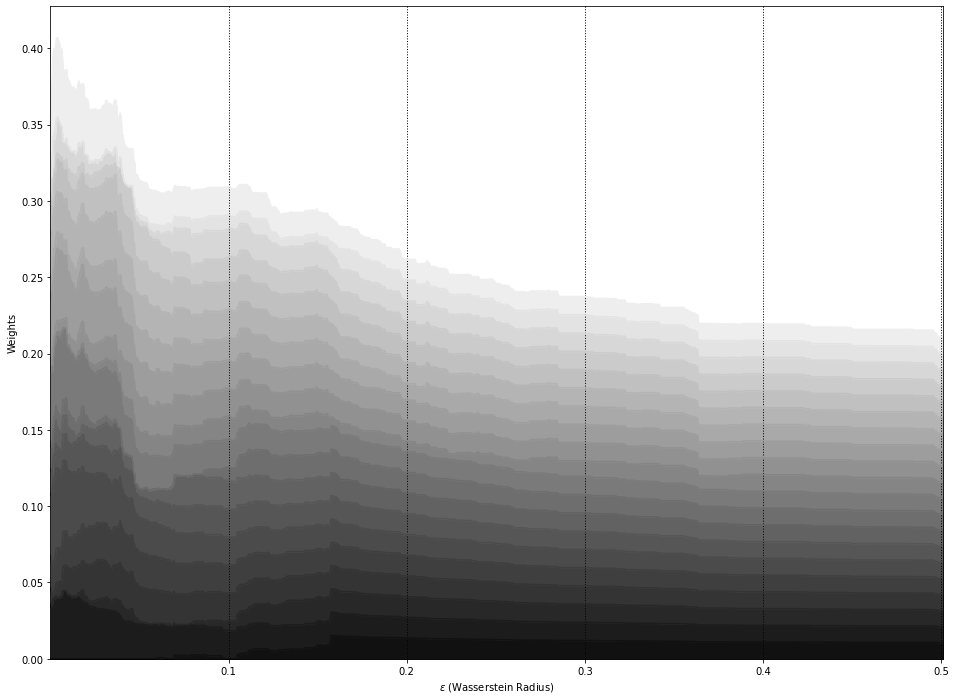

In [44]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = data.iloc[:,:20].plot.area(colormap=my_cmap, xlabel=r'$\epsilon$ (Wasserstein Radius)', ylabel="Weights", figsize=(16, 12))
ax.get_legend().remove()
ax.set_xlim(xmin=10**(-8), xmax=1)
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)